"""
Threshold VAR (TVAR) con datos macro
------------------------------------------------------------------

1) Simula una economía de 3 variables: (y_gap, inflacion, spread).
2) Estima VAR(p) lineal (p por BIC) y TVAR (2 regímenes) con umbral en $spread_{t-d}$.
3) Test bootstrap: mejora en SSE del TVAR vs VAR lineal (resampling vectorial).
4) Estabilidad por régimen (eigenvalores del compañero).
5) GIRFs (Koop–Pesaran–Potter) con identificación Cholesky por régimen.
6) Tablas y gráficos clave.

Dependencias: numpy, pandas, matplotlib
"""

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv, lstsq, cholesky, eigvals
from numpy.linalg import lstsq, eigvals, inv, cholesky


In [13]:
import importlib
import func  # o el nombre del paquete correspondiente
importlib.reload(func)

<module 'func' from 'c:\\Users\\CESAR\\Documents\\GitHub\\Winter-School-Nonlinear-Econometrics\\day05\\tvar\\func.py'>

In [14]:
# =========================
# Utilis
# =========================
from func import lagmat, select_var_lag, companion_max_eig, aic_bic_from_resid, fit_tvar, bootstrap_test_linear_vs_tvar, simulate_tvar_path, tvar_girf, unpack_B, pretty_print_coeffs

In [15]:
# =========================
# 1) Simulación macro sintética con umbral
# =========================
def simulate_macro_tvar(T=600, p_true=2, c_true=0.0, delay_d=1, seed=2025):
    """
    Simula 3 variables: y_gap, inflación, spread.
    Dos regímenes (umbral en spread_{t-d}).
    """
    rng = np.random.default_rng(seed)
    k = 3

    # Matrices por régimen B_s: (1+k*p_true) x k = intercepto + bloques A1..Ap transpuestos
    B1 = np.zeros((1 + k*p_true, k))  # régimen "benigno": persistencia mayor
    B2 = np.zeros((1 + k*p_true, k))  # régimen "tenso" (spread alto): persistencia menor

    # Interceptos
    B1[0,:] = [0.05, 0.02, 0.00]
    B2[0,:] = [-0.05, -0.02, 0.00]

    # A1 y A2 (k x k) por régimen (antes de transponer para apilar en B)
    A1_reg1 = np.array([[0.55, 0.05, -0.05],
                        [0.10, 0.60,  0.00],
                        [0.05, 0.05,  0.50]])
    A2_reg1 = np.array([[0.15, 0.00, -0.02],
                        [0.00, 0.25,  0.00],
                        [0.00, 0.05,  0.20]])

    A1_reg2 = np.array([[0.35, 0.05, -0.15],
                        [0.05, 0.40,  0.10],
                        [0.05, 0.10,  0.55]])
    A2_reg2 = np.array([[0.05, 0.00, -0.05],
                        [0.00, 0.15,  0.05],
                        [0.00, 0.05,  0.25]])

    # Apilar en B1/B2 (transponiendo cada bloque Ai)
    B1[1:1+k,:]        = A1_reg1.T
    B1[1+k:1+2*k,:]    = A2_reg1.T
    B2[1:1+k,:]        = A1_reg2.T
    B2[1+k:1+2*k,:]    = A2_reg2.T

    # Covarianzas por régimen
    Sigma1 = np.array([[0.20, 0.03, 0.00],
                       [0.03, 0.15, 0.02],
                       [0.00, 0.02, 0.10]])
    Sigma2 = np.array([[0.30, 0.05, 0.02],
                       [0.05, 0.25, 0.04],
                       [0.02, 0.04, 0.15]])

    # Simular (warmup + muestra)
    Y = np.zeros((T + 200, k))
    for t in range(p_true, T+200):
        z = Y[t - delay_d, 2]  # spread en t-d
        regime2 = (z > c_true)
        B = B2 if regime2 else B1
        Sigma = Sigma2 if regime2 else Sigma1
        e_t = rng.multivariate_normal(np.zeros(k), Sigma)
        x = [1.0]
        for i in range(1, p_true+1):
            x.extend(Y[t-i, :])
        Y[t,:] = np.asarray(x) @ B + e_t

    Y = Y[-T:, :]
    return Y, ["y_gap","inflation","spread"]

In [16]:
# --- (A) Datos: simular o reemplazar por los tuyos ---
Y, cols = simulate_macro_tvar(T=600, p_true=2, c_true=0.0, delay_d=1, seed=2025)
# Si usas tus datos:
# import your_data_loading as dl
# df = dl.load(...)
# Y = df[["y_gap","inflation","spread"]].dropna().to_numpy(float)
# cols = ["y_gap","inflation","spread"]

k = Y.shape[1]
spread_col = cols.index("spread")

In [24]:
# --- (B) VAR lineal: selección de rezagos y estimación ---
p_star, crit = select_var_lag(Y, pmax=6)
print("\nSelección de rezagos (BIC):\n", crit.assign(chosen=(crit["p"] == p_star)).to_string(index=False))

X_lin, Y_lin = lagmat(Y, p_star)
B_lin = lstsq(X_lin, Y_lin, rcond=None)[0]
U_lin = Y_lin - X_lin @ B_lin
Sigma_lin = (U_lin.T @ U_lin) / U_lin.shape[0]
sse_lin, s2_lin, aic_lin, bic_lin = aic_bic_from_resid(U_lin, n_params=B_lin.size)
print(f"\nVAR lineal (p={p_star}) — SSE={sse_lin:.3f}, sigma2={s2_lin:.4f}, AIC={aic_lin:.2f}, BIC={bic_lin:.2f}")

# --- (C) TVAR: estimación (umbral en spread_{t-1}, d=1) ---
z_series = Y[:, spread_col]
tvar = fit_tvar(Y, p_star, z_series, d=1, q_low=0.15, q_high=0.85, ngrid=61, min_frac=0.15)
print(f"\nTVAR — umbral estimado c ≈ {tvar['c']:.3f}")
sse_tvar, s2_tvar, aic_tvar, bic_tvar = aic_bic_from_resid(
    tvar["resid"], n_params=tvar["B1"].size + tvar["B2"].size + 1
)
print(f"TVAR — SSE={sse_tvar:.3f}, sigma2={s2_tvar:.4f}, AIC={aic_tvar:.2f}, BIC={bic_tvar:.2f}")

# Coeficientes por régimen
pretty_print_coeffs(tvar["B1"], cols, "TVAR — Régimen LOW (z<=c)")
pretty_print_coeffs(tvar["B2"], cols, "TVAR — Régimen HIGH (z>c)")

# Estabilidad por régimen
stab1 = companion_max_eig(tvar["B1"], k, p_star)
stab2 = companion_max_eig(tvar["B2"], k, p_star)
print(f"\nEstabilidad (máx |eigenvalue|): Low={stab1:.3f}, High={stab2:.3f}")

# --- (D) Test bootstrap: VAR vs TVAR ---
delta_obs, deltas, pval = bootstrap_test_linear_vs_tvar(
    Y, p_star, B_lin, z_series, d=1, B=120, seed=7
)
print(f"\nBootstrap test (Δ=SSE_VAR - SSE_TVAR): Δ_obs={delta_obs:.3f}, p-valor≈{pval:.3f}, B={len(deltas)}")

# --- (E) GIRFs por régimen (Cholesky por régimen) ---
# Construir estados iniciales representativos de cada régimen
I2_hat = tvar["I2"]  # True si z>c en cada fila (alineado con Ytrim)
I1_hat = ~I2_hat

def get_init_state(Y, p, mask):
    idx = np.where(mask)[0]
    if len(idx) == 0:
        idx = np.arange(len(Y) - p)  # fallback
    t0 = idx[-1] + p
    return Y[t0 - p : t0, :]

init_low = get_init_state(Y, p_star, I1_hat)
init_high = get_init_state(Y, p_star, I2_hat)

H, R = 24, 250
girf_low_gap = tvar_girf(
    tvar["B1"], tvar["B2"], tvar["c"], p_star, tvar["Sigma1"], tvar["Sigma2"],
    init_low, shock_var=0, horizon=H, R=R, shock_size=1.0, spread_col=spread_col
)
girf_high_gap = tvar_girf(
    tvar["B1"], tvar["B2"], tvar["c"], p_star, tvar["Sigma1"], tvar["Sigma2"],
    init_high, shock_var=0, horizon=H, R=R, shock_size=1.0, spread_col=spread_col
)
girf_low_spr = tvar_girf(
    tvar["B1"], tvar["B2"], tvar["c"], p_star, tvar["Sigma1"], tvar["Sigma2"],
    init_low, shock_var=spread_col, horizon=H, R=R, shock_size=1.0, spread_col=spread_col
)
girf_high_spr = tvar_girf(
    tvar["B1"], tvar["B2"], tvar["c"], p_star, tvar["Sigma1"], tvar["Sigma2"],
    init_high, shock_var=spread_col, horizon=H, R=R, shock_size=1.0, spread_col=spread_col
)



Selección de rezagos (BIC):
  p        SSE          AIC          BIC  chosen
 1 346.517414 -2933.755641 -2881.012502   False
 2 333.286020 -2977.664390 -2885.398984    True
 3 331.995115 -2958.567784 -2826.810271   False
 4 330.631647 -2939.872311 -2768.652925   False
 5 329.379944 -2920.581750 -2709.930803   False
 6 326.766257 -2908.711268 -2658.659147   False

VAR lineal (p=2) — SSE=333.286, sigma2=0.1858, AIC=-2977.66, BIC=-2885.40

TVAR — umbral estimado c ≈ 0.013
TVAR — SSE=319.215, sigma2=0.1779, AIC=-3011.05, BIC=-2822.13

=== TVAR — Régimen LOW (z<=c) ===
Intercepto: {'y_gap': 0.05876714731185457, 'inflation': 0.002963475861234844, 'spread': -0.026999296671737612}

Bloque A1:
                eq_y_gap  eq_inflation  eq_spread
y_gap(t-1)         0.543         0.048     -0.126
inflation(t-1)     0.107         0.633     -0.102
spread(t-1)        0.098        -0.022      0.565

Bloque A2:
                eq_y_gap  eq_inflation  eq_spread
y_gap(t-1)         0.129        -0.027     

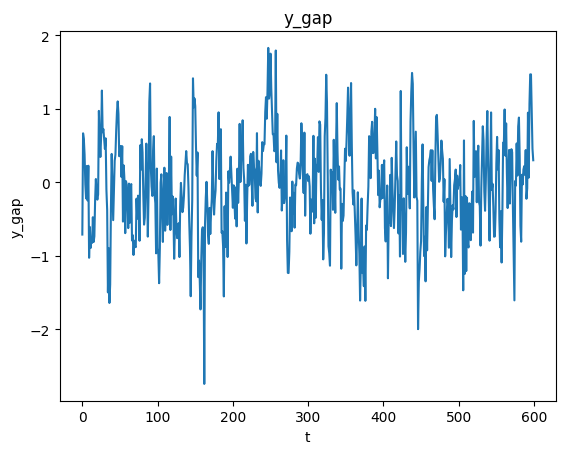

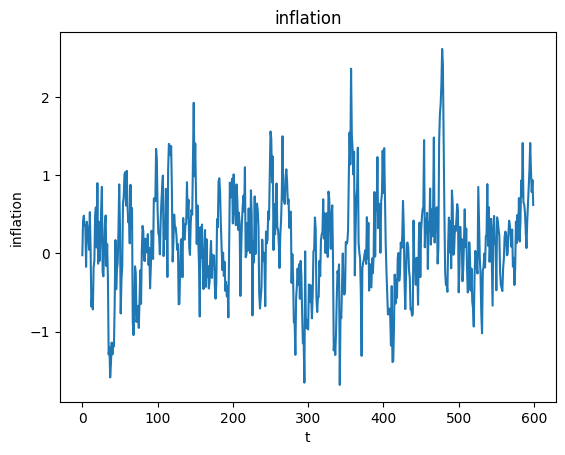

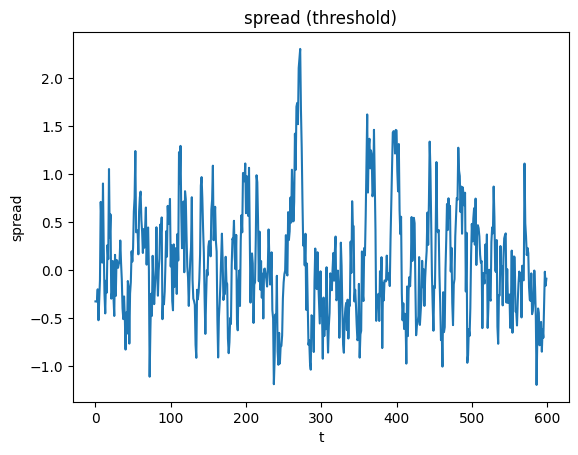

In [18]:
# --- (F) Gráficos  ---
t = np.arange(len(Y))
plt.figure(); plt.plot(t, Y[:,0]); plt.title("y_gap"); plt.xlabel("t"); plt.ylabel("y_gap"); plt.show()
plt.figure(); plt.plot(t, Y[:,1]); plt.title("inflation"); plt.xlabel("t"); plt.ylabel("inflation"); plt.show()
plt.figure(); plt.plot(t, Y[:,2]); plt.title("spread (threshold)"); plt.xlabel("t"); plt.ylabel("spread"); plt.show()



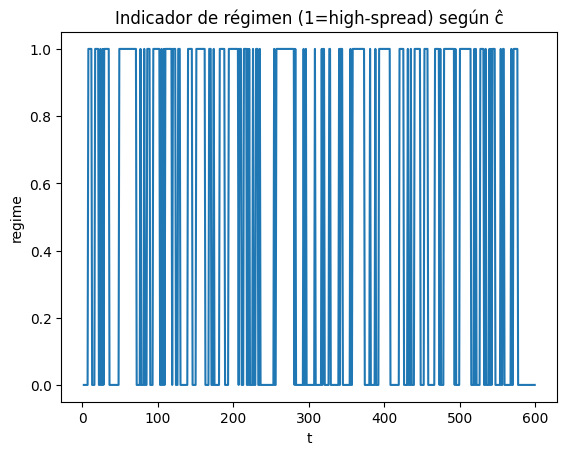

In [19]:
    # Indicador de régimen en tiempo (para t>=p)
plt.figure()
plt.plot(np.arange(p_star, len(Y)), I2_hat.astype(int))
plt.title("Indicador de régimen (1=high-spread) según ĉ"); plt.xlabel("t"); plt.ylabel("regime")
plt.show()

 

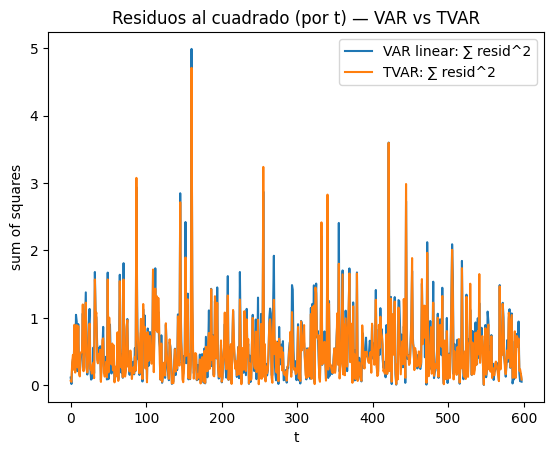

In [20]:
   # Residuos al cuadrado (punto a punto): VAR vs TVAR
res_lin = (Y_lin - X_lin @ B_lin)**2
res_tvar = tvar["resid"]**2
plt.figure()
plt.plot(np.sum(res_lin, axis=1), label="VAR linear: ∑ resid^2")
plt.plot(np.sum(res_tvar, axis=1), label="TVAR: ∑ resid^2")
plt.title("Residuos al cuadrado (por t) — VAR vs TVAR")
plt.xlabel("t"); plt.ylabel("sum of squares"); plt.legend(); plt.show()

 

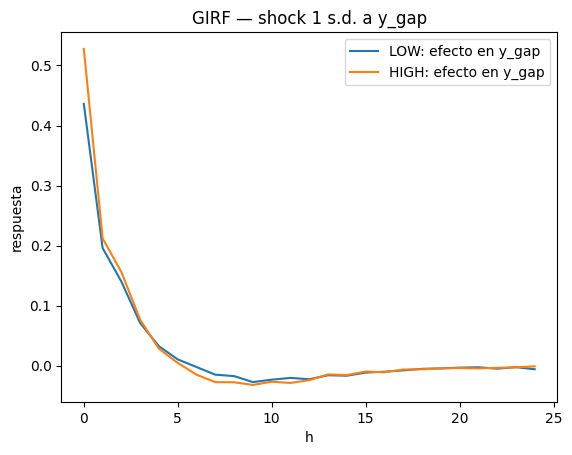

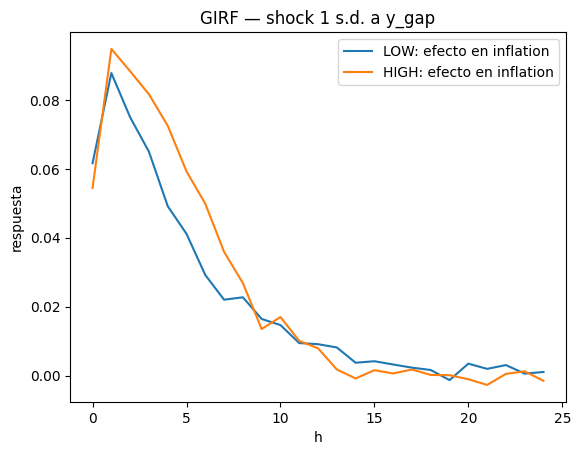

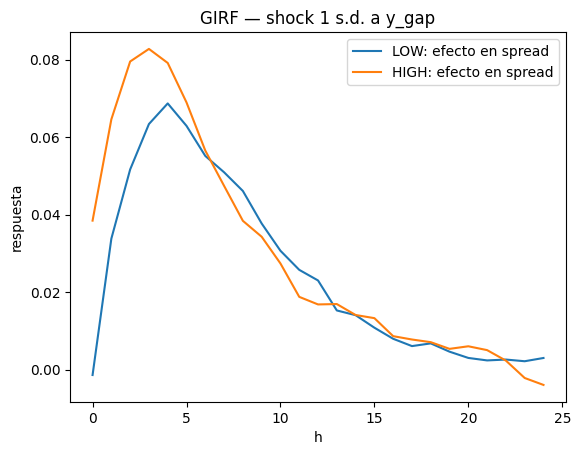

In [21]:
   # GIRFs: shock a y_gap
hgrid = np.arange(H+1)
for j,name in enumerate(cols):
    plt.figure()
    plt.plot(hgrid, girf_low_gap[:,j],  label=f"LOW: efecto en {name}")
    plt.plot(hgrid, girf_high_gap[:,j], label=f"HIGH: efecto en {name}")
    plt.title("GIRF — shock 1 s.d. a y_gap"); plt.xlabel("h"); plt.ylabel("respuesta"); plt.legend(); plt.show()



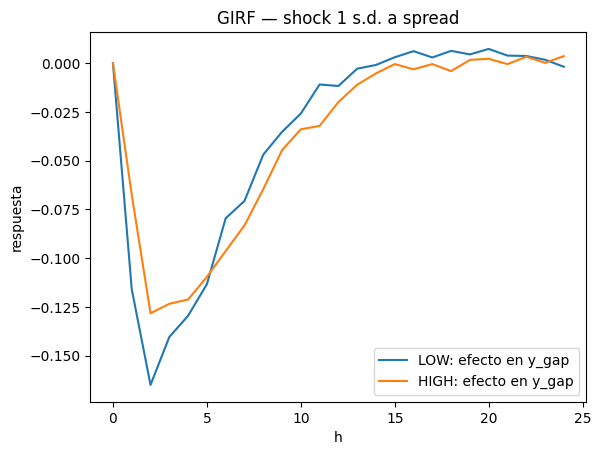

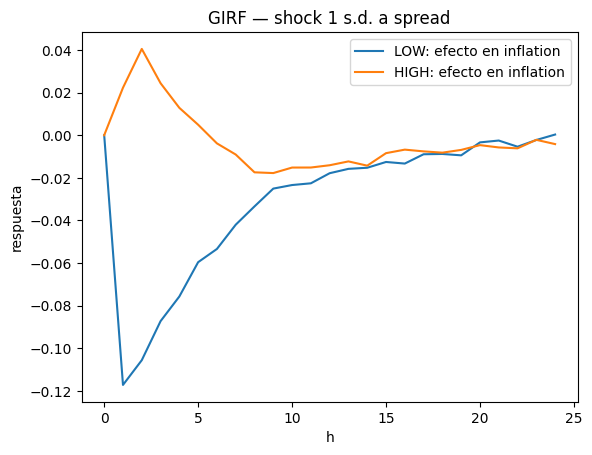

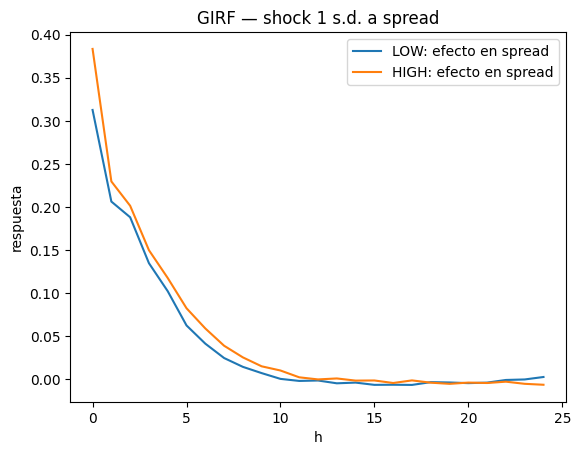

In [22]:
# GIRFs: shock a spread
for j,name in enumerate(cols):
    plt.figure()
    plt.plot(hgrid, girf_low_spr[:,j],  label=f"LOW: efecto en {name}")
    plt.plot(hgrid, girf_high_spr[:,j], label=f"HIGH: efecto en {name}")
    plt.title("GIRF — shock 1 s.d. a spread"); plt.xlabel("h"); plt.ylabel("respuesta"); plt.legend(); plt.show()
